In [1]:
%matplotlib inline


# Faces recognition example using eigenfaces and SVMs

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)


In [2]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

### Step 1. Download the dataset
- Download the data
- Find the number of samples, number of features, number of classes

In [5]:
# Get the the image arrays to find the shapes of the data

nr_samples, h, w = lfw_people.images.shape

# Define X and get shape of data

X = lfw_people.data
nr_features = X.shape[1]

# Predict the label/id of person

y = lfw_people.target
target_names = lfw_people.target_names
nr_classes = target_names.shape[0]

print("Size of Dataset: ")
print("nr_samples: %d" % nr_samples)
print("nr_features: %d" % nr_features)
print("nr_classes: %d" % nr_classes)

Size of Dataset: 
nr_samples: 1288
nr_features: 1850
nr_classes: 7


### Step 2. Train the Model
- Split the data into test and train datasets
- Compute a PCA (eigenfaces) on the face dataset
- Train an SVM Model
- Create a confusion matrix to evaluate the model.

In [6]:
# Split data into traning and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [16]:
# Compute PCA on the face dataset (unsupervised feature extraction/dimensionality reduction)

nr_components = 150

print("Extract the top %d eigenfaces from %d faces"
     % (nr_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=nr_components, svd_solver='randomized',
         whiten=True).fit(X_train)
print("done in %0.3fs" % (time()-t0))

ef = pca.components_.reshape((nr_components, h, w))

print("Project input data on the eigenfaces orthonormal basis")
t0=time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time()-t0))

Extract the top 150 eigenfaces from 966 faces
done in 0.095s
Project input data on the eigenfaces orthonormal basis
done in 0.008s


In [18]:
# Train SVM Classification Model

print("Fit classification model to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
             'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
classifier = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid)
classifier = classifier.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time()-t0))
print("Best estimator from grid search: ")
print(classifier.best_estimator_)

Fit classification model to the training set
done in 12.265s
Best estimator from grid search: 
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


In [20]:
# Quantitative evaluation of model on test set

print("Predict people's names on the test set")
t0 = time()
y_pred = classifier.predict(X_test_pca)
print("done in %0.3fs" % (time()-t0))

print(classification_report(y_test, y_pred, target_names = target_names))
print(confusion_matrix(y_test, y_pred, labels=range(nr_classes)))

Predict people's names on the test set
done in 0.077s
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.54      0.67        13
     Colin Powell       0.75      0.87      0.81        60
  Donald Rumsfeld       0.80      0.59      0.68        27
    George W Bush       0.86      0.97      0.91       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       0.97      0.81      0.88        36

         accuracy                           0.85       322
        macro avg       0.89      0.73      0.79       322
     weighted avg       0.86      0.85      0.85       322

[[  7   2   0   4   0   0   0]
 [  1  52   2   5   0   0   0]
 [  0   4  16   7   0   0   0]
 [  0   4   0 142   0   0   0]
 [  0   1   0   3  20   0   1]
 [  0   5   0   1   1   8   0]
 [  0   1   2   4   0   0  29]]


In [21]:
# Qualitative evaluation of predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col = 4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=0.99, top=0.9, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(images[i].reshape((h,w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

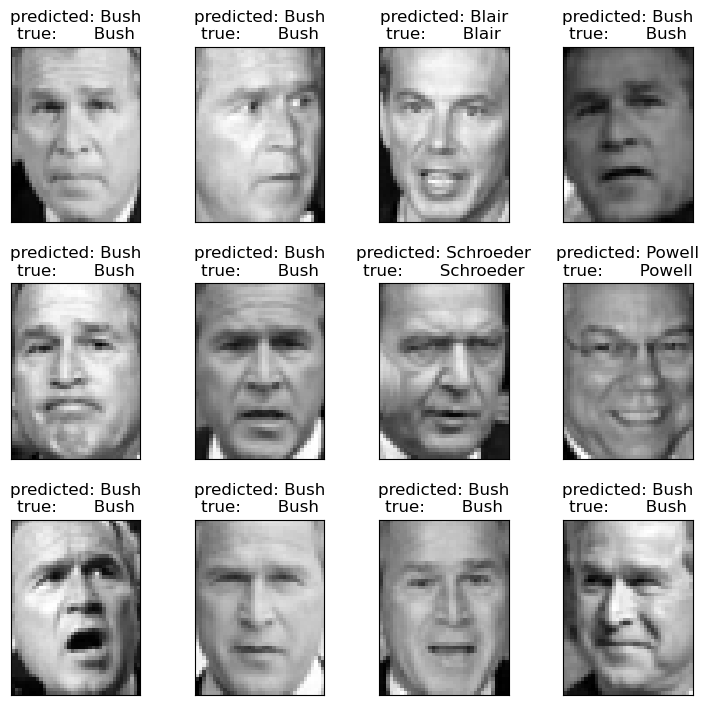

In [23]:
# Plot the results on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    real_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:       %s' % (pred_name, real_name)

pred_title = [title(y_pred, y_test, target_names, i)
             for i in range(y_pred.shape[0])]

plot_gallery(X_test, pred_title, h, w)

# Plot the most significant eigenfaces

plt.show()